In [4]:
#去除脸部图片的白色标签
import os
import os.path
import sys
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import cv2
import hashlib
import random

In [27]:
def imshow(img):
    s=img.shape
    if len(s)>2:
        b,g,r=cv2.split(img)
        img=cv2.merge([r,g,b])
    else:
        img=cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [22]:
def label_and_rect(im,lower,upper):
    hsv=cv2.cvtColor(im,cv2.COLOR_BGR2HSV)
    #高斯模糊
    GaussianBlurSize=5
    imggauss=cv2.GaussianBlur(im,(51,51),GaussianBlurSize)
    #白色范围
    #lower=np.array([0,0,200])
    #upper=np.array([180,40,255])
    mask=cv2.inRange(hsv,lower,upper)
    res=cv2.bitwise_and(imggauss,imggauss,mask=mask)
    #灰度化
    img=cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
    #二值化
    ret,thresh = cv2.threshold(img,100,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #闭操作
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
    imgclose = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    #求轮廓
    (contours, _) = cv2.findContours(imgclose.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #排除qingse
    imgc=imgclose
    con=sorted(contours,key=cv2.contourArea,reverse=True)            
    ret=[]
    for i,c in enumerate(con):
        x,y,w,h=cv2.boundingRect(c)
        if w<90 or w>220:
            continue
        ret.append((x,y,w,h))

    if len(ret) == 0:
        return None
    #从二值化原图中取各轮廓中均值最大的一个    
    val=[]
    for i,v in enumerate(ret):
        x,y,w,h=v
        rect=im[y:y+h,x:x+w]
        mean=np.mean(rect)
        val.append((mean,v))
    val=sorted(val,reverse=True)
    roi=val[0][1]
    print roi
    px=random.randint(1,im.shape[1]-1)
    py=random.randint(1,im.shape[0]-1)
    imgrect = im.copy()    
    #for i,v in enumerate(ret):
        #x,y,w,h=v
        #b,g,r=imgrect[py][px]    
        #cv2.rectangle(imgrect,(x,y),(x+w,y+h),(int(b),int(g),int(r)),-1)
    
    x,y,w,h=roi
    b,g,r=imgrect[py][px]
    cv2.rectangle(imgrect,(x,y),(x+w,y+h),(int(b),int(g),int(r)),-1)
    return imgrect

(220, 184, 115, 51)


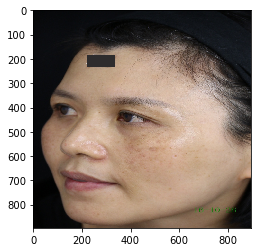

In [32]:
#调试label_and_rect
im=cv2.imread('/home/wang/data_eva_1/huangheban/ture/3.jpg')
wlower=np.array([0,0,200])
wupper=np.array([180,40,255])
imshow(label_and_rect(im,wlower,wupper))

In [33]:
dict1={'taitianzhi': '5bbdb707', 'false': '6f691f7e', 'heqingsezhi': 'bf81bd1f', 'huangheban': '0151f6ac', 'sezhi': 'a2683c1f', 'queban': 'e598ef8b', 'ture': '85ad5a4c', 'riguangxingheizhi': '13e9e528', 'kafeiban': '3976fbec'}
dict2={'3976fbec': 'kafeiban', '6f691f7e': 'false', '13e9e528': 'riguangxingheizhi', 'bf81bd1f': 'heqingsezhi', '0151f6ac': 'huangheban', '5bbdb707': 'taitianzhi', 'e598ef8b': 'queban', '85ad5a4c': 'ture', 'a2683c1f': 'sezhi'}
#目录名编码和反编码
def get_class_torf_hash(jpgpath):  #path: xxx/yyy/zzz/classname/trueorfalse/
    #apath=os.path.split(jpgpath)[0]
    #print apath
    classname=jpgpath.split('/')
    cname=classname[len(classname)-2]
    torf=classname[len(classname)-1]
    return dict1[cname],dict1[torf]

def get_name_from_hash(hashcode):
    return dict2[hashcode]

In [39]:
SOURCEPATH='/home/wang/data_eva_1/'         #存放分类图片
OUTPUTPATH='/home/wang/data_eva_1_out_2/'  #混合存放将分类图片盖掉标签，文件名包含分类和TF信息
RESTOREPATH='/home/wang/git/nppic/data_eva_1_restore/'#将文件名包含编码分类和TF信息的文件，根据文件名恢复分类
#白色
wlower=np.array([0,0,200])
wupper=np.array([180,40,255])
#青色
qlower=np.array([78,43,46]) 
qupper=np.array([99,255,255])
#混合图片
err=0
cnt=0
for parent,dirnames,filenames in os.walk(SOURCEPATH):
    for fname in filenames:
        if fname.endswith('.jpg')==False and fname.endswith('.JPG')==False:
            continue
        im=cv2.imread(os.path.join(parent,fname))            
        imr= label_and_rect(im,wlower,wupper)
        if imr==None:
            imr= label_and_rect(im,qlower,qupper)  #白色试不出就青色
        cnt=cnt+1
        if imr==None:
            print "{} has no roi".format(os.path.join(parent,fname))
            err=err+1
            continue
        classhash,torfhash=get_class_torf_hash(parent)
        f=fname.split('.')
        newfname='{}-{}-{}.jpg'.format(f[0],classhash,torfhash)
        newpathname=os.path.join(OUTPUTPATH,newfname)
        cv2.imwrite(newpathname,imr)
print "all: {}, err: {}".format(cnt,err)
print 'over'

(272, 551, 153, 72)
(232, 291, 140, 124)
(242, 637, 115, 66)
(256, 685, 142, 74)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(720, 424, 155, 84)
(113, 569, 121, 68)
(600, 598, 132, 72)
(219, 680, 150, 85)
(348, 187, 133, 70)
(110, 158, 123, 80)
(262, 231, 148, 86)
(363, 741, 179, 107)
(177, 502, 143, 70)
(717, 340, 98, 131)
(329, 695, 208, 104)
(564, 450, 151, 80)
(131, 565, 177, 104)
(595, 724, 129, 85)
(293, 588, 157, 97)
(407, 622, 128, 68)
(214, 143, 136, 79)
/home/wang/data_eva_1/riguangxingheizhi/false/126.jpg has no roi
(117, 733, 91, 53)
(1, 170, 172, 431)
(215, 696, 137, 67)
(415, 759, 121, 63)
(697, 668, 140, 73)
/home/wang/data_eva_1/riguangxingheizhi/false/26.jpg has no roi
(374, 589, 132, 70)
(388, 506, 174, 91)
(288, 168, 100, 59)
(106, 325, 137, 93)
(716, 842, 163, 36)
(665, 327, 97, 34)
(129, 681, 129, 74)
(646, 563, 122, 70)
(449, 731, 129, 63)
(234, 691, 185, 102)
(143, 492, 145, 78)
(213, 337, 142, 80)
(457, 30, 124, 68)
(384, 615, 190, 121)
(467, 625, 149, 71)
(399, 553, 159, 84)
(199, 667, 144, 81)
(720, 845, 157, 31)
(258, 585, 184, 97)
(525, 669, 140, 72)
(428, 605, 154, 78)
(326, 677,

In [35]:
#测试目录递归
PATH='/home/wang/git/nppic/recu'
#for parent,dirnames,filenames in os.walk(PATH):
#    for fname in filenames:
#        p=fname.split('.')
#        if p[1]=='jpg' or p[1]=='JPG':
#            print parent,fname
#dict={'taitianzhi': '5bbdb707', 'false': '6f691f7e', 'heqingsezhi': 'bf81bd1f', 'huangheban': '0151f6ac', 'sezhi': 'a2683c1f', 'queban': 'e598ef8b', 'ture': '85ad5a4c', 'riguangxingheizhi': '13e9e528', 'kafeiban': '3976fbec'}
#dict={'3976fbec': 'kafeiban', '6f691f7e': 'false', '13e9e528': 'riguangxingheizhi', 'bf81bd1f': 'heqingsezhi', '0151f6ac': 'huangheban', '5bbdb707': 'taitianzhi', 'e598ef8b': 'queban', '85ad5a4c': 'ture', 'a2683c1f': 'sezhi'}
a1=['heqingsezhi','huangheban','kafeiban','queban','riguangxingheizhi','sezhi','taitianzhi','false','ture']
dic1={}
dic2={}
md5=hashlib.md5()
for i,v in enumerate(a1):
    md5.update(v)
    s=md5.hexdigest()
    print s[24:32],v
    dic1[v]=s[24:32]
    dic2[s[24:32]]=v
print dic1,dic2

bf81bd1f heqingsezhi
0151f6ac huangheban
3976fbec kafeiban
e598ef8b queban
13e9e528 riguangxingheizhi
a2683c1f sezhi
5bbdb707 taitianzhi
6f691f7e false
85ad5a4c ture
{'taitianzhi': '5bbdb707', 'false': '6f691f7e', 'heqingsezhi': 'bf81bd1f', 'huangheban': '0151f6ac', 'sezhi': 'a2683c1f', 'queban': 'e598ef8b', 'ture': '85ad5a4c', 'riguangxingheizhi': '13e9e528', 'kafeiban': '3976fbec'} {'3976fbec': 'kafeiban', '6f691f7e': 'false', '13e9e528': 'riguangxingheizhi', 'bf81bd1f': 'heqingsezhi', '0151f6ac': 'huangheban', '5bbdb707': 'taitianzhi', 'e598ef8b': 'queban', '85ad5a4c': 'ture', 'a2683c1f': 'sezhi'}


In [36]:
#PICFILE='/home/wang/git/nppic/data_eva_1/heqingsezhi/ture/0.jpg'
#PICFILE='/home/wang/git/nppic/data_eva_1/heqingsezhi/ture/65.jpg'
PICFILE='/home/wang/git/nppic/data_eva_1/sezhi/ture/705.jpg'
#PICFILE='/home/wang/git/nppic/data_eva_1/heqingsezhi/ture/523.jpg'
#PICFILE='/home/wang/git/nppic/data_eva_1/queban/ture/464.jpg'
im=cv2.imread(PICFILE)
imshow(im)

AttributeError: 'NoneType' object has no attribute 'shape'

In [37]:
hsv=cv2.cvtColor(im,cv2.COLOR_BGR2HSV)

error: /build/buildd/opencv-2.4.8+dfsg1/modules/imgproc/src/color.cpp:3959: error: (-215) (scn == 3 || scn == 4) && (depth == CV_8U || depth == CV_32F) in function cvtColor


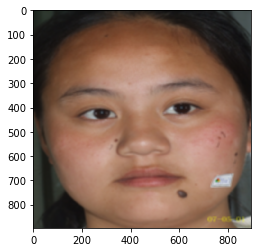

In [62]:
GaussianBlurSize=5
imggauss=cv2.GaussianBlur(im,(11,11),GaussianBlurSize)
imshow(imggauss)

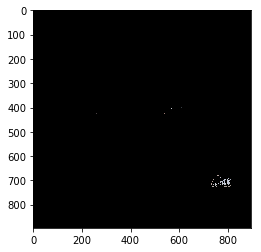

In [63]:
#阈值和掩模
lower=np.array([0,0,221]) 
upper=np.array([180,30,255])
#lower=np.array([78,43,46]) 
#upper=np.array([99,255,255])
mask=cv2.inRange(hsv,lower,upper)
res=cv2.bitwise_and(imggauss,imggauss,mask=mask)
imshow(res)

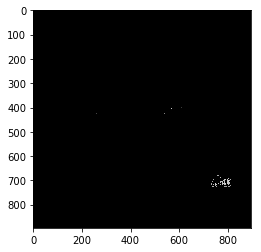

In [64]:
img=cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
imshow(img)

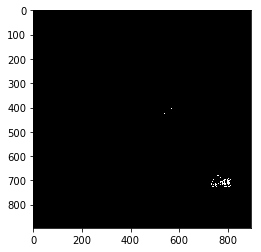

In [65]:
#二值化
ret,thresh = cv2.threshold(img,100,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
imshow(thresh)

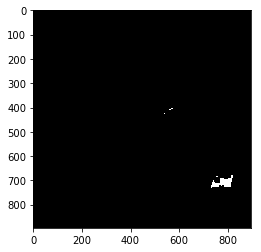

In [66]:
#闭操作
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10, 10))
imgclose = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
imshow(imgclose)

In [67]:
#轮廓
(contours, _) = cv2.findContours(imgclose.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [68]:
imgc=imgclose
con=sorted(contours,key=cv2.contourArea,reverse=True)            
ret=[]
for i,c in enumerate(con):
    x,y,w,h=cv2.boundingRect(c)
    #正常宽度450左右
    if w<90:
        continue
    #ratio=float(w)/float(h)
    #if ratio<1.35 or ratio>1.55:
    #    continue
    ret.append((x,y,w,h))
print len(ret)
print ret


1
[(732, 680, 91, 50)]


In [69]:
#从二值化中取均值最大的一个
val=[]
for i,v in enumerate(ret):
    x,y,w,h=v
    roi=im[y:y+h,x:x+w]
    mean=np.mean(roi)
    val.append((mean,v))
print val    
val=sorted(val,reverse=True)
roi=val[0][1]
print roi

[(180.25509157509157, (732, 680, 91, 50))]
(732, 680, 91, 50)


33 47 75


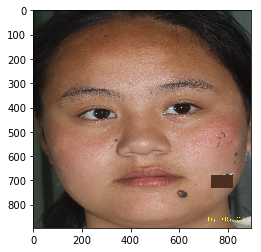

In [73]:
imgrect = im.copy()
px=random.randint(1,im.shape[1])
py=random.randint(1,im.shape[0])

b,g,r=imgrect[py][py]
x,y,w,h=roi
print b,g,r
#cv2.rectangle(imgrect,(x,y),(x+w,y+h),(0,0,255),-1)
cv2.rectangle(imgrect,(x,y),(x+w,y+h),(int(b),int(g),int(r)),-1)
imshow(imgrect)    